In [3]:
# %%
# Imports
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from scipy.stats import iqr
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D
import os

# Définition de la constante (selon votre script initial)
K_OPTIMAL = 3 
# Attention: Dans les Tâches 5 et 6, le code semble utiliser K=6 implicitement
# pour les visualisations (TSNE, PCA). Assurez-vous d'ajuster K_OPTIMAL si votre
# méthode du coude (Tâche 5) indique K=6 ou autre.
print(f"Imports et constantes chargées. K_OPTIMAL est défini à {K_OPTIMAL}.")

Imports et constantes chargées. K_OPTIMAL est défini à 3.


In [4]:

# ----------------------------------------------------------------
# PHASE 5: PROFILAGE ET INTERPRÉTATION (Tâche 8)
# ----------------------------------------------------------------

print("--- Début de la Tâche 8 : Profilage des Clusters ---")

# 1. Chargement des données clustérisées (avec les labels de cluster)
df_clustered = pd.read_csv("network_traffic_clustered.csv")

# 2. Calcul des caractéristiques moyennes par cluster
# Nous utilisons la moyenne et la médiane pour les colonnes numériques clés
cluster_summary = df_clustered.groupby('Cluster')[['FlowDuration', 'TotalPackets', 'TotalBytes', 
                                                     'PacketRate', 'ByteRate', 'Port', 
                                                     'AvgPacketSize', 'InterArrivalTime']].mean()

# Afficher les caractéristiques numériques moyennes
print("\n--- Statistiques Moyennes des Clusters (Profil Numérique) ---")
print(cluster_summary.to_markdown(numalign="left", stralign="left", floatfmt=".2f"))

--- Début de la Tâche 8 : Profilage des Clusters ---

--- Statistiques Moyennes des Clusters (Profil Numérique) ---
| Cluster   | FlowDuration   | TotalPackets   | TotalBytes   | PacketRate   | ByteRate   | Port     | AvgPacketSize   | InterArrivalTime   |
|:----------|:---------------|:---------------|:-------------|:-------------|:-----------|:---------|:----------------|:-------------------|
| 0         | 1249.32        | 35498.14       | 324821163.35 | 358.94       | 8087075.76 | 1406.49  | 1394.73         | 0.02               |
| 1         | 13.31          | 70.57          | 1026455.36   | 18.53        | 19971.44   | 1542.32  | 386.76          | 1.10               |
| 2         | 2747.91        | 94660.08       | 24513441.83  | 126.98       | 269234.15  | 34589.68 | 297.83          | 0.03               |


In [5]:
# %%
# ----------------------------------------------------------------
# PHASE 1 & 2: NETTOYAGE DES DONNÉES (Tâche 2)
# ----------------------------------------------------------------

print("--- Début du Nettoyage des Données (Tâche 2) ---")

# 1. Chargement du fichier brut
df = pd.read_csv("network_traffic_raw.csv")
rows_before = len(df)

# 2. Correction des Valeurs Invalides/Négatives (Remplacer par NaN)
numeric_cols_to_check = ['FlowDuration', 'TotalPackets', 'TotalBytes', 'PacketRate']
for col in numeric_cols_to_check:
    df[col] = df[col].apply(lambda x: np.nan if x < 0 else x)

# 3. Standardisation de la colonne 'Protocol'
df['Protocol'] = df['Protocol'].str.strip().str.lower()
df['Protocol'] = df['Protocol'].replace({'t.c.p': 'tcp', 'u.d.p': 'udp'})

# 4. Suppression des lignes avec valeurs manquantes (pour un dataset complet)
# CORRECTION 1: Utiliser .copy() pour créer explicitement un nouveau DataFrame modifiable
df_clean = df.dropna().copy() 
rows_after_drop = len(df_clean)
print(f"Lignes supprimées (NaN/Négatives) : {rows_before - rows_after_drop}")
print(f"Lignes conservées : {rows_after_drop}")

# 5. Traitement des Valeurs Aberrantes (Outliers) par Plafonnement (Capping IQR)
outlier_cols = ['FlowDuration', 'TotalPackets', 'TotalBytes', 'ByteRate', 'PacketRate']
for col in outlier_cols:
    Q1 = df_clean[col].quantile(0.25)
    Q3 = df_clean[col].quantile(0.75)
    IQR_val = Q3 - Q1
    upper_bound = Q3 + 1.5 * IQR_val
    
    # CORRECTION 2: Utiliser .loc pour la modification
    df_clean.loc[df_clean[col] > upper_bound, col] = upper_bound

# Sauvegarder le fichier nettoyé
df_clean.to_csv("network_traffic_clean.csv", index=False)
print("Fichier 'network_traffic_clean.csv' créé (Nettoyage Tâche 2 terminé).")
# Affiche les 5 premières lignes
df_clean.head()

--- Début du Nettoyage des Données (Tâche 2) ---
Lignes supprimées (NaN/Négatives) : 317
Lignes conservées : 1508
Fichier 'network_traffic_clean.csv' créé (Nettoyage Tâche 2 terminé).


,FlowID,FlowDuration,TotalPackets,TotalBytes,AvgPacketSize,BytesPerPacket,PacketRate,ByteRate,FlowVolume,Port,Protocol,FIN_Flag_Count,SYN_Flag_Count,RST_Flag_Count,PSH_Flag_Count,ACK_Flag_Count,InterArrivalTime
0,1754,13.630383,45.000,9115.0,172.158655,202.555556,1.636552,8.129805e+02,1.108124e+04,443,udp,1,0,0,2,17,5.371397
1,1497,1.363091,2.000,897.0,178.883791,2242.500000,5.657161,8.729823e+02,1.189954e+03,53,udp,0,0,0,0,0,1.083918
2,47,1.757574,106.000,40022.0,460.794804,377.566038,48.542320,4.793957e+03,8.425734e+03,443,tcp,2,3,0,41,67,0.397586
3,875,2719.887078,8067.000,56485098.0,1459.106676,7001.995537,396.033906,5.995752e+06,1.630777e+10,1935,tcp,1,2,0,975,941,0.002830
4,1662,2446.741965,100923.875,25419456.0,166.363776,199.643869,91.550664,2.797563e+05,6.844916e+08,38192,udp,1,1,0,5691,6344,0.009545


--- Début de la Tâche 3 : Analyse Exploratoire des Données (Création de graphiques) ---


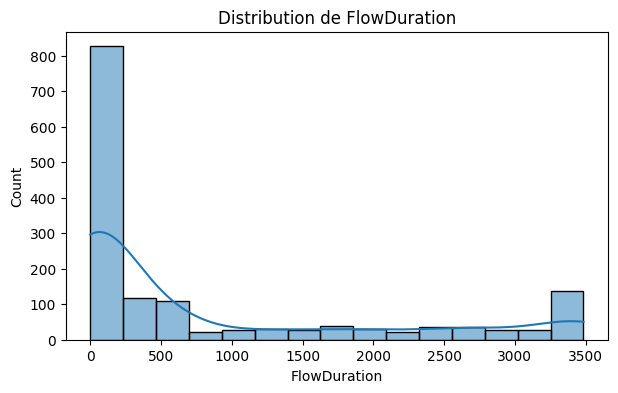

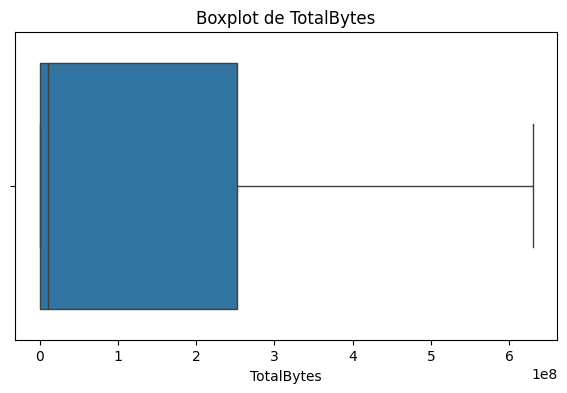

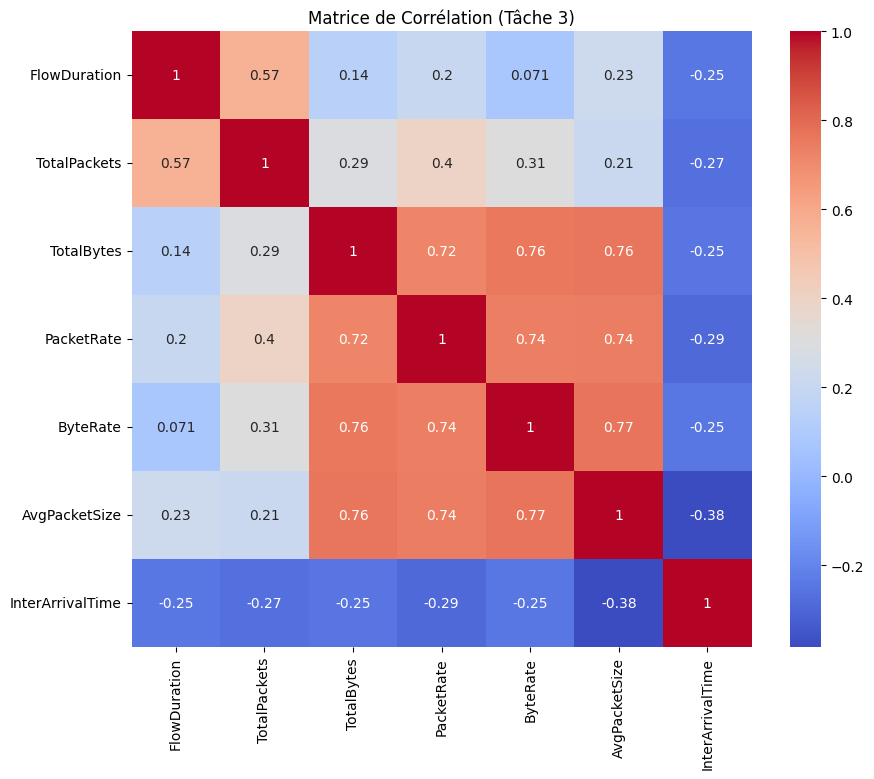

In [6]:
# ----------------------------------------------------------------
# Cellule 3 : PHASE 8 - ANALYSE EXPLORATOIRE DES DONNÉES (Tâche 3)
# ----------------------------------------------------------------

print("--- Début de la Tâche 3 : Analyse Exploratoire des Données (Création de graphiques) ---")

os.makedirs("plots_hist", exist_ok=True)
os.makedirs("plots_box", exist_ok=True)
os.makedirs("plots_heatmap", exist_ok=True)

numeric_cols = [
    'FlowDuration', 'TotalPackets', 'TotalBytes',
    'PacketRate', 'ByteRate', 'AvgPacketSize', 'InterArrivalTime'
]

# 1. Exemple d'affichage direct d'un histogramme (le Notebook affichera le graphique)
plt.figure(figsize=(7, 4))
sns.histplot(df_clean['FlowDuration'], kde=True)
plt.title("Distribution de FlowDuration")
plt.show() # Affiche le graphique dans le Notebook

# 2. Boxplot (exemple)
plt.figure(figsize=(7, 4))
sns.boxplot(x=df_clean['TotalBytes'])
plt.title("Boxplot de TotalBytes")
plt.show()

# 3. Heatmap de corrélation
plt.figure(figsize=(10, 8))
sns.heatmap(df_clean[numeric_cols].corr(), annot=True, cmap="coolwarm")
plt.title("Matrice de Corrélation (Tâche 3)")
plt.show()

In [7]:
# ----------------------------------------------------------------
# Cellule 4 : PHASE 3 - MISE À L'ÉCHELLE POUR K-MEANS (Tâche 4)
# ----------------------------------------------------------------

print("--- Début de la Préparation K-Means (Tâche 4) ---")

# 1. Sélection et Encodage des Caractéristiques
df_features = df_clean.drop(columns=['FlowID'])
df_encoded = pd.get_dummies(df_features, columns=['Protocol'], drop_first=False)
df_encoded = df_encoded.drop(columns=['Protocol_?', 'Protocol_unknown'], errors='ignore')

# 2. Mise à l'Échelle (Scaling) des Caractéristiques
scaler = StandardScaler()
df_scaled_data = scaler.fit_transform(df_encoded)
df_scaled = pd.DataFrame(df_scaled_data, columns=df_encoded.columns)

# 3. Vérification des statistiques (la magie du Notebook est d'afficher le résultat)
print("\nStatistiques après standardisation (Moyenne ≈ 0, Écart-type ≈ 1) :")
df_scaled[['FlowDuration', 'TotalBytes', 'PacketRate']].describe().loc[['mean', 'std']]

--- Début de la Préparation K-Means (Tâche 4) ---

Statistiques après standardisation (Moyenne ≈ 0, Écart-type ≈ 1) :


,FlowDuration,TotalBytes,PacketRate
mean,6.125368e-17,3.533866e-17,3.180480e-17
std,1.000332e+00,1.000332e+00,1.000332e+00


--- Début de la Tâche 5 : Détermination du K Optimal (Méthode du Coude) ---


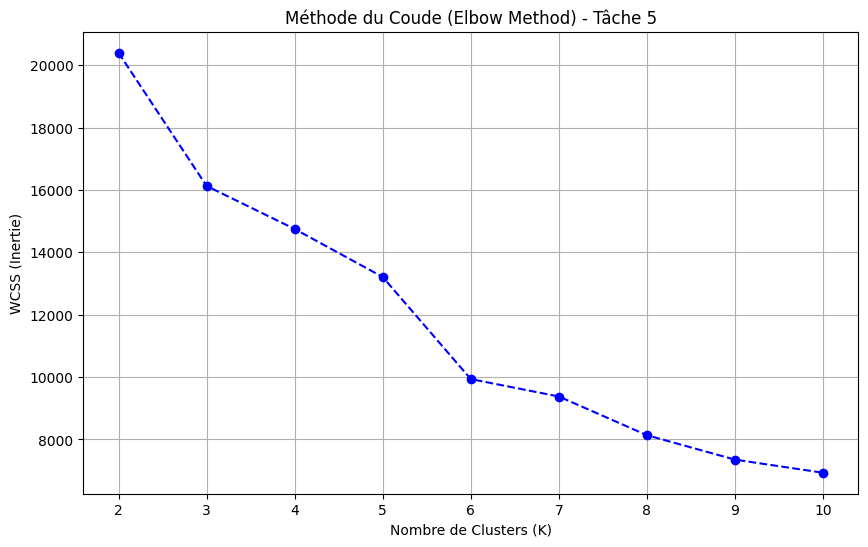


Courbe du Coude affichée. Observez l'endroit où la courbe 'casse' (le coude).


<Figure size 640x480 with 0 Axes>

In [8]:
# ----------------------------------------------------------------
# Cellule 5 : PHASE 4 - DÉTERMINATION DU K OPTIMAL (Tâche 5)
# ----------------------------------------------------------------

print("--- Début de la Tâche 5 : Détermination du K Optimal (Méthode du Coude) ---")

# Chargement des données mises à l'échelle (si la cellule 4 n'est pas exécutée avant)
# df_scaled = pd.read_csv("network_traffic_scaled.csv") 

wcss = []
k_range = range(2, 11) # Tester K de 2 à 10

# Calcul de la WCSS
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto') 
    kmeans.fit(df_scaled)
    wcss.append(kmeans.inertia_) 

# Affichage de la Courbe du Coude directement dans le Notebook
plt.figure(figsize=(10, 6))
plt.plot(k_range, wcss, marker='o', linestyle='--', color='blue')
plt.title("Méthode du Coude (Elbow Method) - Tâche 5")
plt.xlabel("Nombre de Clusters (K)")
plt.ylabel("WCSS (Inertie)")
plt.xticks(k_range)
plt.grid(True)
plt.show() # Affiche le graphique
plt.savefig("courbe_du_coude.png") # Sauvegarde pour le rapport

print("\nCourbe du Coude affichée. Observez l'endroit où la courbe 'casse' (le coude).")

--- Début de la Tâche 6 : K-Means avec K=3 ---
Clustering Terminé. Clusters ajoutés à df_clean.


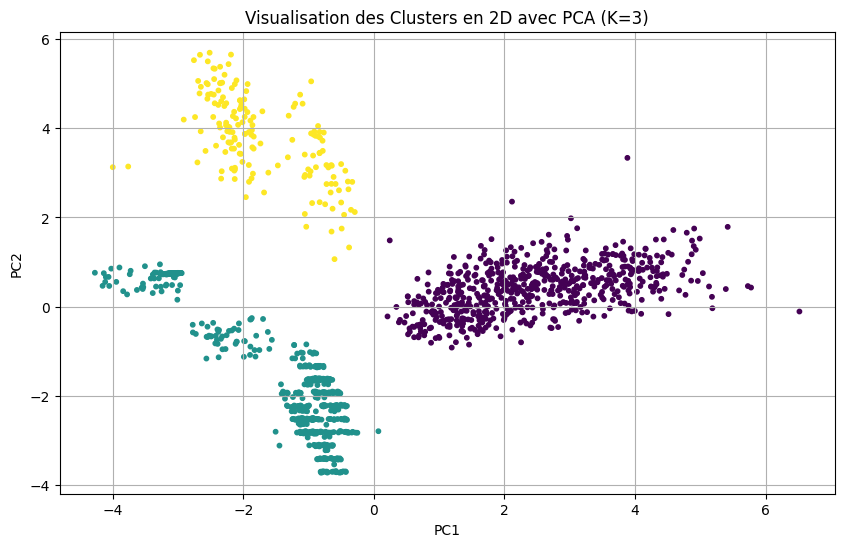

<Figure size 640x480 with 0 Axes>

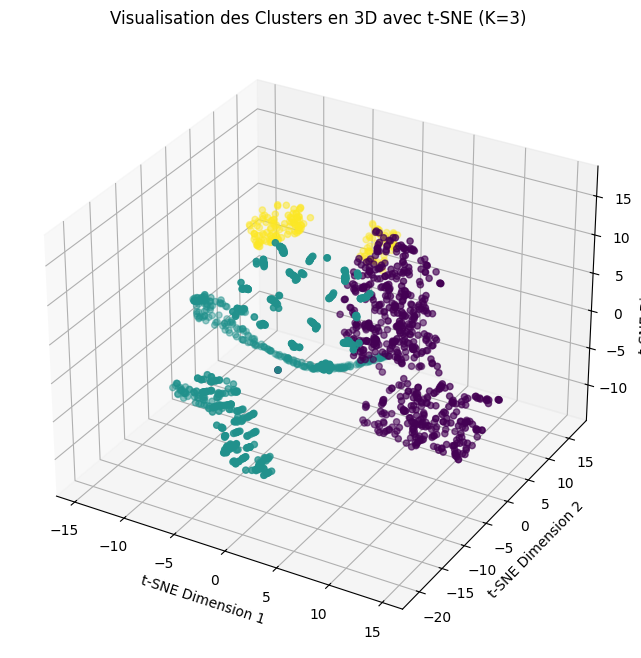

<Figure size 640x480 with 0 Axes>

In [9]:
# ----------------------------------------------------------------
# Cellule 6 : PHASE 4 (suite) & 6 - K-MEANS FINAL et Visualisation PCA/t-SNE (Tâche 6)
# ----------------------------------------------------------------

print(f"--- Début de la Tâche 6 : K-Means avec K={K_OPTIMAL} ---")

kmeans_final = KMeans(n_clusters=K_OPTIMAL, random_state=42, n_init='auto')
cluster_labels = kmeans_final.fit_predict(df_scaled)

# Attribution des labels aux données non-mises à l'échelle
df_clean['Cluster'] = cluster_labels
df_clean.to_csv("network_traffic_clustered.csv", index=False)

print(f"Clustering Terminé. Clusters ajoutés à df_clean.")

## Visualisation des Clusters avec PCA
os.makedirs("plots_pca", exist_ok=True)
pca = PCA(n_components=2)
pca_data = pca.fit_transform(df_scaled)

plt.figure(figsize=(10, 6))
plt.scatter(pca_data[:, 0], pca_data[:, 1], c=cluster_labels, s=10, cmap='viridis')
plt.title(f"Visualisation des Clusters en 2D avec PCA (K={K_OPTIMAL})")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.show()
plt.savefig("plots_pca/visualisation_pca_clusters.png")

## Visualisation 3D avec t-SNE
os.makedirs("plots_tsne", exist_ok=True)
tsne = TSNE(n_components=3, random_state=42, n_jobs=-1, perplexity=30, init='pca', learning_rate='auto') 
tsne_data_3d = tsne.fit_transform(df_scaled)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(tsne_data_3d[:, 0], tsne_data_3d[:, 1], tsne_data_3d[:, 2], 
                     c=cluster_labels, cmap='viridis', s=20)
ax.set_title(f"Visualisation des Clusters en 3D avec t-SNE (K={K_OPTIMAL})")
ax.set_xlabel("t-SNE Dimension 1")
ax.set_ylabel("t-SNE Dimension 2")
ax.set_zlabel("t-SNE Dimension 3") 
plt.show()
plt.savefig(f"plots_tsne/visualisation_tsne_3d_clusters_k{K_OPTIMAL}.png")

In [10]:
# ----------------------------------------------------------------
# Cellule 7 : PHASE 6 - ÉVALUATION DES CLUSTERS (Tâche 7)
# ----------------------------------------------------------------

print("\n--- Début de la Tâche 7 : Évaluation des Clusters ---")

# X est df_scaled, labels est cluster_labels
X = df_scaled
labels = cluster_labels 

sil_score = silhouette_score(X, labels)
db_score = davies_bouldin_score(X, labels)
ch_score = calinski_harabasz_score(X, labels)

print(f"Silhouette Score (Idéal près de 1) : {sil_score:.4f}")
print(f"Davies-Bouldin Index (Idéal près de 0) : {db_score:.4f}")
print(f"Calinski-Harabasz Index (Plus élevé est mieux) : {ch_score:.4f}")


--- Début de la Tâche 7 : Évaluation des Clusters ---
Silhouette Score (Idéal près de 1) : 0.3402
Davies-Bouldin Index (Idéal près de 0) : 1.2324
Calinski-Harabasz Index (Plus élevé est mieux) : 513.9820


In [12]:
# ----------------------------------------------------------------
# Cellule 8 : PHASE 5 - PROFILAGE ET INTERPRÉTATION (Tâche 8)
# ----------------------------------------------------------------

print("--- Début de la Tâche 8 : Profilage des Clusters ---")

# 1. Calcul des caractéristiques moyennes par cluster
cluster_summary_num = df_clean.groupby('Cluster')[['FlowDuration', 'TotalPackets', 'TotalBytes', 
                                                   'PacketRate', 'ByteRate', 'Port', 
                                                   'AvgPacketSize', 'InterArrivalTime']].mean()

# Afficher les caractéristiques numériques moyennes (affichage automatique du DataFrame)
print("\n--- Statistiques Moyennes des Clusters (Profil Numérique) ---")
cluster_summary_num

# 2. Analyser les protocoles dominants
print("\n--- Protocoles Dominants par Cluster ---")
protocol_distribution = df_clean.groupby('Cluster')['Protocol'].value_counts(normalize=True).mul(100).rename('Percent').reset_index()

# Afficher le protocole le plus fréquent pour chaque cluster
dominant_protocols = protocol_distribution.loc[
    protocol_distribution.groupby('Cluster')['Percent'].idxmax()
]
dominant_protocols

--- Début de la Tâche 8 : Profilage des Clusters ---

--- Statistiques Moyennes des Clusters (Profil Numérique) ---

--- Protocoles Dominants par Cluster ---


,Cluster,Protocol,Percent
0,0,tcp,99.678973
3,1,tcp,65.507650
7,2,udp,65.060241


In [13]:

# 3. Analyser les protocoles dominants
print("\n--- Protocoles Dominants par Cluster ---")
protocol_distribution = df_clustered.groupby('Cluster')['Protocol'].value_counts(normalize=True).mul(100).rename('Percent').reset_index()

# Afficher le protocole le plus fréquent pour chaque cluster
dominant_protocols = protocol_distribution.loc[
    protocol_distribution.groupby('Cluster')['Percent'].idxmax()
]
print(dominant_protocols.to_markdown(numalign="left", stralign="left", floatfmt=".1f"))


--- Protocoles Dominants par Cluster ---
|    | Cluster   | Protocol   | Percent   |
|:---|:----------|:-----------|:----------|
| 0  | 0         | tcp        | 99.7      |
| 3  | 1         | tcp        | 65.5      |
| 7  | 2         | udp        | 65.1      |



--- Début de la Tâche 7 : Évaluation des Clusters ---
Silhouette Score : 0.3402
Davies-Bouldin Index : 1.2324
Calinski-Harabasz Index : 513.9820
